In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import optuna
from sklearn.model_selection import KFold,cross_val_score,cross_validate
from sklearn.metrics import accuracy_score



C:\Users\imyme\anaconda3\envs\flask\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#データ取得
df_train = pd.read_csv("../main/data/train.csv")


In [6]:
#Max_HRについて変換
df_train['MaxHR_2']=207-df_train['Age']*0.7-df_train['MaxHR']

In [7]:

#特徴量作成
"""
df_train['H_risk']='HR0'
for i in range(len(df_train)):
    #修正:Downはリスク低い
    if -0.3<df_train.loc[i,'Oldpeak']<0.3 and df_train.loc[i,'ST_Slope']=='Flat':
        df_train.loc[i,'H_risk']='HR2'
    elif 0.3<=df_train.loc[i,'Oldpeak']<2.5 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='HR1'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.5 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='HR3'
    elif df_train.loc[i,'Oldpeak']>=2.5 or df_train.loc[i,'Oldpeak']<=-0.3:
        df_train.loc[i,'H_risk']='HR4'
    else:
        pass
"""
    
df_train['H_risk']='Risk0'
for i in range(len(df_train)):
    if abs(df_train.loc[i,'Oldpeak'])<0.3 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk4'
    elif 0.3<=df_train.loc[i,'Oldpeak']<1.8 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='Risk1'
    elif 0.3<=df_train.loc[i,'Oldpeak']<1.8 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='Risk2'
    elif 1.8<=df_train.loc[i,'Oldpeak']<2.5:
        df_train.loc[i,'H_risk']='Risk3'
    elif df_train.loc[i,'Oldpeak']>=2.5 or df_train.loc[i,'Oldpeak']<=-0.3:
        df_train.loc[i,'H_risk']='Risk5'
    else:
        pass


df_train['CholCat']='chol0'
for i in range(len(df_train)):
    if 200>df_train.loc[i,'Cholesterol']>0:
        df_train.loc[i,'CholCat']='chol1'
    if 240>df_train.loc[i,'Cholesterol']>=200:
        df_train.loc[i,'CholCat']='chol2'
    elif 280>df_train.loc[i,'Cholesterol']>=240:
        df_train.loc[i,'CholCat']='chol3'
    elif df_train.loc[i,'Cholesterol']>=280:
        df_train.loc[i,'CholCat']='chol4'
    else:
        pass

    
#TAとNAPをTA+NAPとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_train.loc[df_train['ChestPainType']=='TA','ChestPainType']='TA+NAP'
df_train.loc[df_train['ChestPainType']=='NAP','ChestPainType']='TA+NAP'
df_train['ChestPainType'].unique()


#OneHotencoder

#ChestPainType,RestingECG,ST_SlopをOneHotEncoding
df_train=df_train.join(pd.get_dummies(df_train['ChestPainType']))
df_train=df_train.join(pd.get_dummies(df_train['RestingECG']))
df_train=df_train.join(pd.get_dummies(df_train['CholCat']))
df_train=df_train.join(pd.get_dummies(df_train['H_risk']))
df_train=df_train.join(pd.get_dummies(df_train['ST_Slope']))


#ラベルエンコーダーでエンコーディング
CPT_mapping = {'ASY':2, 'TA+NAP':1, 'ATA':0}
df_train['cpt_l'] = df_train['ChestPainType'].map(CPT_mapping)

RECG_mapping = {'ST':1, 'LVH':2, 'Normal':0}
df_train['recg_l'] = df_train['RestingECG'].map(RECG_mapping)

Hrisk_mapping = {'Risk0':0, 'Risk1':1, 'Risk2':2,'Risk3':3,'Risk4':4,'Risk5':5}
df_train['H_risk_l'] = df_train['H_risk'].map(Hrisk_mapping)

Chol_mapping = {'chol0':4, 'chol1':0, 'chol2':1,'chol3':2,'chol4':3}
df_train['chol_l'] = df_train['CholCat'].map(Chol_mapping)


Slop_mapping = {'Up':0, 'Flat':2, 'Down':1}
df_train['slop_l'] = df_train['ST_Slope'].map(Slop_mapping)




#cholesterol値以外の数値データを標準化

#データ標準化する対象を選択
numeric_features=['Age','RestingBP', 'MaxHR','Cholesterol','Oldpeak']


In [12]:
df_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,Risk4,Risk5,Down,Flat,Up,cpt_l,recg_l,H_risk_l,chol_l,slop_l
0,56,1,ASY,155,342,1,Normal,150,1,3.0,...,0,1,0,1,0,2,0,5,3,2
1,55,0,ATA,130,394,0,LVH,150,0,0.0,...,0,0,0,0,1,0,2,0,3,0
2,47,1,TA+NAP,110,0,1,Normal,120,1,0.0,...,1,0,0,1,0,1,0,4,4,2
3,34,1,ASY,115,0,1,Normal,154,0,0.2,...,0,0,0,0,1,2,0,0,4,0
4,54,0,TA+NAP,160,201,0,Normal,163,0,0.0,...,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,48,1,ASY,106,263,1,Normal,110,0,0.0,...,1,0,0,1,0,2,0,4,2,2
638,53,1,ASY,126,0,0,Normal,106,0,0.0,...,1,0,0,1,0,2,0,4,4,2
639,54,1,ASY,200,198,0,Normal,142,1,2.0,...,0,0,0,1,0,2,0,3,0,2
640,45,0,ATA,130,237,0,Normal,170,0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [23]:
target = "HeartDisease"
features_d3 = ['Age','Sex','RestingBP','FastingBS','MaxHR','Cholesterol','Oldpeak','cpt_l','recg_l','slop_l']
features_d4 = ['Age','Sex','RestingBP','FastingBS','MaxHR_2','Cholesterol','Oldpeak','cpt_l','recg_l','slop_l']
features_kawa=['Age','Sex','cpt_l','RestingBP','chol_l','FastingBS','recg_l','ExerciseAngina','H_risk_l','MaxHR']#採用
features_kawa2=['Age','Sex','RestingBP','Cholesterol','FastingBS','chol_l','recg_l','ExerciseAngina','H_risk_l']

In [28]:
#params= {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 4,'class_weight':'balanced','random_state':82,'n_estimators':1000}
#params= {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 2,'class_weight':'balanced','random_state':82,'n_estimators':1000}
params= {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 23, 'min_samples_leaf': 8, 'max_features': 2,'class_weight':'balanced','random_state':82,'n_estimators':1000}
#params= {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 2,'class_weight':'balanced','random_state':82,'n_estimators':1000}
RFC = RandomForestClassifier(**params)

#特徴量選択
features=features_kawa

#5分割公差検証
#変数
X_RFC = df_train[features]
Y = df_train[target]

#交差検証
score_RFC = cross_val_score(RFC, X_RFC, Y, cv=5)  

#正解率を出力する
print(f"スコア LC 交差バージョン: {score_RFC}")
print("")

#平均値を出力する
print(f"平均値 LC 交差バージョン： {score_RFC.mean()}")
print("")

スコア LC 交差バージョン: [0.87596899 0.86046512 0.9296875  0.8671875  0.890625  ]

平均値 LC 交差バージョン： 0.8847868217054262



スコア LC 交差バージョン: [0.87596899 0.89147287 0.8984375  0.8671875  0.875     ]

平均値 LC 交差バージョン： 0.8816133720930232

In [33]:
#それぞれの特徴量の係数
RFC.fit(X_RFC,Y)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=4, min_samples_split=8,
                       n_estimators=1000, random_state=82)

In [34]:
#結果を入れるためのDataFrame
df_coef=pd.DataFrame()

for i in range(len(features)):
    #print(features[i],':',LR.coef_[0,i])
    df_coef.loc[i,'features']=features[i]
    df_coef.loc[i,'coef']=RFC.feature_importances_[i]

#降順に並べる
df_coef=df_coef.sort_values('coef',ascending=False)

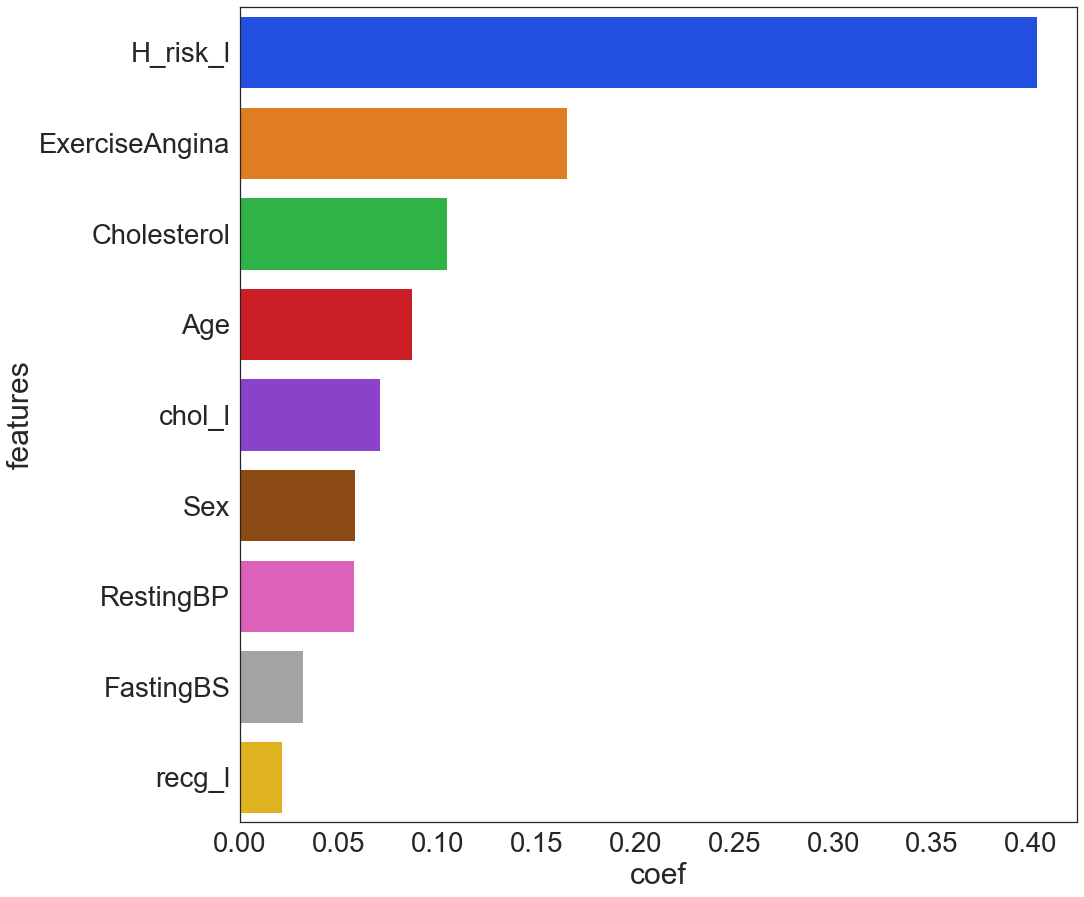

In [35]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2.5,style='white',palette='bright')
sns.barplot(df_coef,x='coef',y='features')
plt.show()

In [40]:
#データ取得用公差検証

#Kfoldでtrainとtestのindexを取得
kf = KFold(n_splits=5,shuffle=True,random_state=46)

#df_trainの行を準備
df_train[['RFC_prob','RFC_pred']]=0

val_pred=[]
val_lists=[]
val_pred_acc=[]

#foldした分だけpredictを回す(公差検証)
for i,(train_index,val_index) in enumerate(kf.split(df_train)):
    
    #validationのindexを取得
    val_lists.append(val_index)
    
    #それぞれのモデルのfit
    RFC.fit(X_RFC.loc[train_index,:],Y[train_index])

    #それぞれのモデルでtestをpredict_prabaして確率を保存
    RFC_proba=RFC.predict_proba(X_RFC.loc[val_index,:])
    
    #df_trainに心臓病確率を入れる
    df_train.loc[val_index,'RFC_prob']=RFC_proba[:,1]

    #df_trainに心臓病予測を入れる
    df_train.loc[val_index,'RFC_pred']=RFC.predict(X_RFC.loc[val_index,:])
    
    #正答率をリストに入れる
    val_pred_acc.append(accuracy_score(df_train.loc[val_index,'HeartDisease'].values,df_train.loc[val_index,'RFC_pred'].values))
    

    
#公差検証の結果
print('5分割:',val_pred_acc)
print('5分割平均:',sum(val_pred_acc)/len(val_pred_acc))

#データ全体の正答率
print('全体:',accuracy_score(df_train['HeartDisease'].values,df_train['RFC_pred'].values))

5分割: [0.8914728682170543, 0.8682170542635659, 0.84375, 0.9296875, 0.8515625]
5分割平均: 0.8769379844961239
全体: 0.8769470404984424


5分割: [0.9147286821705426, 0.8682170542635659, 0.8359375, 0.953125, 0.8671875]
5分割平均: 0.8878391472868217
全体: 0.8878504672897196

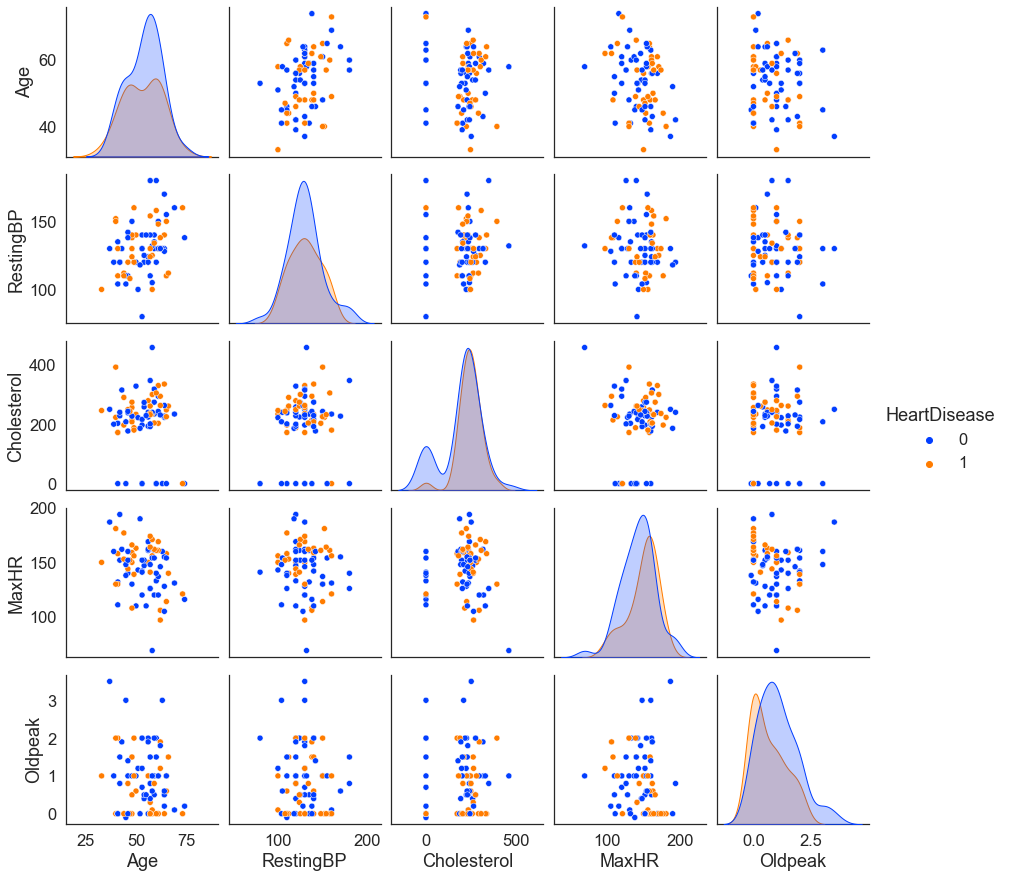

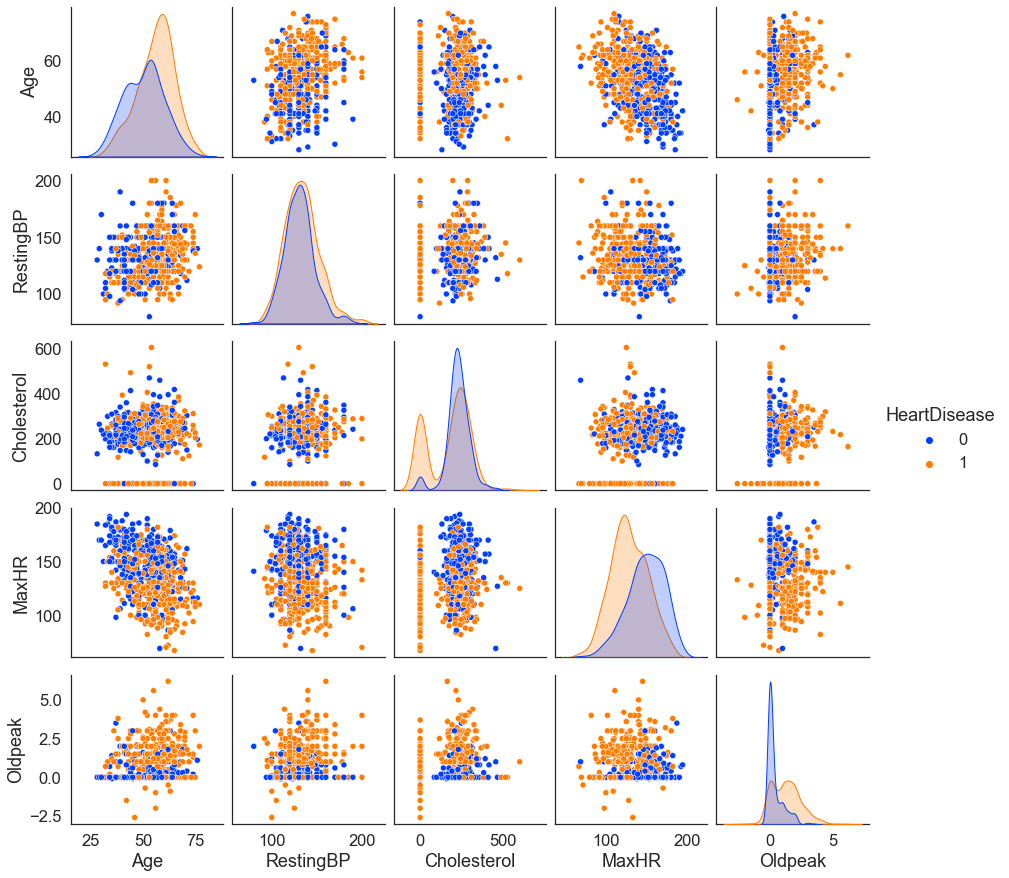

In [41]:
#正解の場合"1"になる列を作成

#seabornのグラフ設定
sns.set(font_scale=1.5,style='white',palette='bright')

df_train['ACC_RFC']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'RFC_pred']:
        df_train.loc[i,'ACC_RFC']=1
    else:
        pass


#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC_RFC==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')

#図を保存する場合に実行
#plt.savefig('./WrongAnswers/LR_dummy1.png')

#比較用に、元データのpairplotも表示
sns.pairplot(df_train,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')
plt.show()

In [42]:
#予測と正解のクロス集計表
pd.crosstab(df_train['HeartDisease'],df_train['RFC_pred'])

RFC_pred,0,1
HeartDisease,,
0,237,46
1,33,326


In [34]:
#それぞれの特徴量の係数
RFC.fit(X_DC,Y)

# 決定木モデルをDOTデータに変換
dot_data = export_graphviz(RFC,                              # 決定木モデルを指定
                                out_file = None,                    # 出力ファイルではなく文字列を返すように指定
                                feature_names = features, # 特徴量の表示名を指定
                                class_names = target,    # クラス分類の表示名を指定
                                filled = True)                      # 多数派クラスでノードを色付け

# ダイアグラムを描画
graph = pydotplus.graph_from_dot_data(dot_data)  

# ダイアグラムを表示
Image(graph.create_png())

NameError: name 'export_graphviz' is not defined

In [25]:


#クラス作成
class Objective():
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # 損失関数
            'criterion' : trial.suggest_categorical('criterion',['gini','entropy']),
            # 深さ
            'max_depth': trial.suggest_categorical('max_depth', [4,5,6,7,8,9,10,11]),
            #min_sample_split
            'min_samples_split':trial.suggest_int('min_samples_split',10,30),
            #min_samples_leaf
            'min_samples_leaf':trial.suggest_int('min_samples_leaf',4,20),
            'max_features':trial.suggest_int('max_features',2,3),
            #min_weight_fraction_leaf
            #'min_weight_fraction_leaf':trial.suggest_float('min_weight_fraction_leaf',0,0.5),
            #min_impurity_decrease
            #'min_impurity_decrease':trial.suggest_float('min_impurity_decrease',0,3),
            #class_weight
            'n_estimators':700,
            'class_weight':'balanced',#trial.suggest_categorical('class_weight',['balanced','None']),
            # 正則化の種類(elastic netは別枠でやる)
            #'ccp_alpha':trial.suggest_float('ccp_alpha',0,2)
            'random_state':82
            }

        model = RandomForestClassifier(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, 
                                y=self.y,
                                scoring='accuracy', # 正解率を指定（https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter）
                                n_jobs=-1) # 並行して実行するジョブの数（-1は全てのプロセッサを使用）
        return scores['test_score'].mean()


    
    
    

In [26]:
objective = Objective(X_RFC, Y)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize') # 最大化
study.optimize(objective,n_trials=300)

# ベストパラメータを出力
print('params:', study.best_params)
print('score:', study.best_value)

params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 23, 'min_samples_leaf': 8, 'max_features': 2}
score: 0.8863372093023255


params: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 2}
score: 0.8832000968992247

params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 2}

params: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 3}
score: 0.8816497093023254

params: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 3} score: 0.8816497093023254

params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 3}

In [35]:
def objective(trial):
    # ハイパーパラメータの設定
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)
    max_features = trial.suggest_int('max_features',3,6)

    # モデルのインスタンスを作成
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # 交差検証によるモデルの評価
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # 評価スコアの平均値を返す
    return np.mean(scores)

In [36]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

In [37]:
study.optimize(objective, n_trials=300)

[W 2023-03-06 18:00:05,042] Trial 0 failed with parameters: {'n_estimators': 437, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 3} because of the following error: NameError("name 'X' is not defined").
Traceback (most recent call last):
  File "C:\Users\imyme\anaconda3\envs\flask\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\imyme\AppData\Local\Temp\ipykernel_10756\794757145.py", line 22, in objective
    for train_index, test_index in kf.split(X):
NameError: name 'X' is not defined
[W 2023-03-06 18:00:05,044] Trial 0 failed with value None.


NameError: name 'X' is not defined

In [9]:
print('Best trial:')
trial = study.best_trial
print(f'  Score: {trial.value:.11f}')
print('  Params: ')
for k, v in trial.params.items():
    print(f'    {k}: {v}')

Best trial:
  Score: 0.88476259690
  Params: 
    n_estimators: 542
    max_depth: 7
    min_samples_split: 3
    min_samples_leaf: 4
    max_features: 4
